# Problem statement: 
> To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

# Steps 

- Data Reading - Loading
- Dataset Creation
- Dataset Visualization
- Model 1 Building , Training , Evaluation and Findings -- CNN Model with Dropout layer
- Model 2 Building , Training , Evaluation and Findings -- CNN Model with Augment strategy and Dropout layer
- Model 3 Building , training , Evaluation and Findings - CNN Model with Augmentor to rectify imbalance class data

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [11]:
from __future__ import print_function
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical
from tensorflow.keras.regularizers import l2

In [12]:
# #If you are using the data by mounting the google drive, use the following :
# from google.colab import drive
# drive.mount('/content/gdrive')

# ##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [13]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/Volumes/MyFiles/MachineLearning/upgrad/LiveCourse/Deep Learning/CNN/Convolutional-Neural-Networks-main/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/Volumes/MyFiles/MachineLearning/upgrad/LiveCourse/Deep Learning/CNN/Convolutional-Neural-Networks-main/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [14]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [15]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [16]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  labels='inferred',
  validation_split=0.2,
  color_mode='rgb',
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [17]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  labels='inferred',
  validation_split=0.2,
  color_mode='rgb',
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [18]:
## Write your test dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  labels='inferred',
  color_mode='rgb',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [19]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

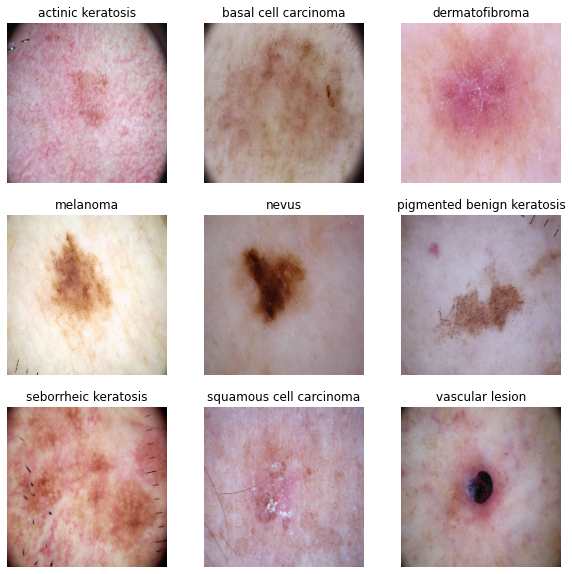

In [21]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

fig = plt.figure(figsize=(10, 10))

classes = range(len(class_names))
for images, labels in val_ds.take(1):
    missing = []
    for i in classes:
        ax = fig.add_subplot(3, 3, 1 + i)
        x = np.where(labels[:]==i)[0]
        if len(x) > 0:
            idx = np.where(labels[:]==i)[0][0]
            im = images[idx].numpy().astype("uint8")
            plt.imshow(im)
            plt.title(class_names[labels[idx]])
            plt.axis("off")
        else:
            missing.append(i) # Appending list for missing classes
    if len(missing) > 0:
        classes = missing
        continue
    else:
        break

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [22]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [23]:
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
]


# Model 1

In [24]:
### Your code goes here

input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential()
#normalisation layer
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
# First Conv layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding ='same' ,input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding ='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding ='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding ='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9,kernel_regularizer=l2(0.01)))
model.add(Activation('softmax'))

## Number of classes is 9
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 128)       0

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [25]:
from tensorflow.keras.optimizers import Adam
### Todo, choose an appropirate optimiser and loss function
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=['accuracy'])

In [26]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)

In [27]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,callbacks=[learning_rate_reduction]
)

Epoch 1/20


/Users/shashankbhatnagar/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/backend.py:4929: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(
2022-04-20 00:11:02.617532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


56/56 [==============================] - ETA: 0s - loss: 2.2558 - accuracy: 0.1914

2022-04-20 00:11:15.737974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


56/56 [==============================] - 15s 188ms/step - loss: 2.2558 - accuracy: 0.1914 - val_loss: 1.9579 - val_accuracy: 0.2953
Epoch 2/20
56/56 [==============================] - 10s 181ms/step - loss: 1.9009 - accuracy: 0.3225 - val_loss: 1.7125 - val_accuracy: 0.4251
Epoch 3/20
56/56 [==============================] - 10s 176ms/step - loss: 1.8080 - accuracy: 0.3666 - val_loss: 1.6485 - val_accuracy: 0.4430
Epoch 4/20
56/56 [==============================] - 10s 175ms/step - loss: 1.6447 - accuracy: 0.4297 - val_loss: 1.5322 - val_accuracy: 0.4743
Epoch 5/20
56/56 [==============================] - 10s 172ms/step - loss: 1.5318 - accuracy: 0.4743 - val_loss: 1.4810 - val_accuracy: 0.4944
Epoch 6/20
56/56 [==============================] - 10s 171ms/step - loss: 1.4665 - accuracy: 0.5067 - val_loss: 1.4290 - val_accuracy: 0.5078
Epoch 7/20
56/56 [==============================] - 10s 174ms/step - loss: 1.4343 - accuracy: 0.5106 - val_loss: 1.5159 - val_accuracy: 0.4720
Epoch 8/20

### Visualizing training results

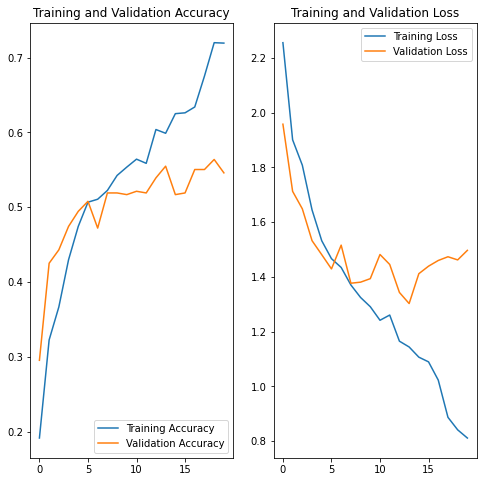

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [29]:

loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)


# Thus we can clearly see that model Overfit and we need to chose right data augumentation strategy

14/14 [==============================] - 1s 55ms/step - loss: 1.4968 - accuracy: 0.5459
Accuracy:  0.7371652126312256
Validation Accuracy:  0.5458613038063049
Loss:  0.7240530252456665
Validation Loss 1.4968253374099731


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

# Model 1 Findings:
- -  With the increase in the no of epochs training accuracy increased Final accuracy: 0.73
- - Validation accuracy increases for some ecpochs and then becomes constant Final accuracy .54
- -  Since there is a difference in training accuracy and validation accuracy this model is overfitting
- -  Training loss decreses with increase in epochs but validation loss decreases first with increse in epochs and then become constant.
- -  Overfitting happened since we have less number of training images and model has learnt from noise or unwanted details around the training data.
- -  We will use data augmentation to counter overfitting.
- -  Data augmentation will add additional training data by applying transformation on existing data. This will expose the model to more aspects of the data.

# Model 2

In [30]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
with tf.device('/CPU:0'):
    data_augmentation = keras.Sequential(
      [
       # Random flip of image of horizontal axis
        layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
       # Random rotation of image
        layers.experimental.preprocessing.RandomRotation(0.2),
       # Random zoom of image
        layers.experimental.preprocessing.RandomZoom(0.2),
      ]
    )

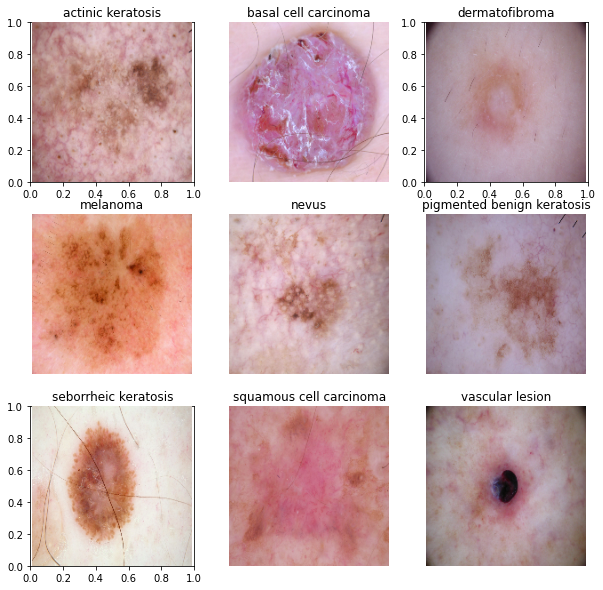

In [31]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

fig = plt.figure(figsize=(10, 10))

classes = range(len(class_names))
for images, labels in val_ds.take(2):
    missing = []
    for i in classes:
        ax = fig.add_subplot(3, 3, 1 + i)
        x = np.where(labels[:]==i)[0]
        if len(x) > 0:
            idx = np.where(labels[:]==i)[0][0]
            augmented_images = data_augmentation(images)
            im = images[idx].numpy().astype("uint8")
            plt.imshow(im)
            plt.title(class_names[labels[idx]])
            plt.axis("off")
        else:
            missing.append(i) # Appending list for missing classes
    if len(missing) > 0:
        classes = missing
        continue
    else:
        break

### Todo:
### Create the model, compile and train the model


In [32]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

### Your code goes here

input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential()
#normalisation layer
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
# First Conv layer
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding ='same' ,input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding ='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding ='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding ='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding ='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9,kernel_regularizer=l2(0.01)))
model.add(Activation('softmax'))

## Number of classes is 9
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 22, 22, 64)       

### Compiling the model

In [33]:
## Your code goes here
from tensorflow.keras.optimizers import Adam
### Todo, choose an appropirate optimiser and loss function
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=['accuracy'])

### Training the model

In [34]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[learning_rate_reduction]
)

Epoch 1/20


2022-04-20 00:15:42.237946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


56/56 [==============================] - ETA: 0s - loss: 2.1905 - accuracy: 0.1808

2022-04-20 00:15:47.172422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


56/56 [==============================] - 6s 94ms/step - loss: 2.1905 - accuracy: 0.1808 - val_loss: 2.0893 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 5s 87ms/step - loss: 2.0088 - accuracy: 0.2606 - val_loss: 1.8336 - val_accuracy: 0.3132
Epoch 3/20
56/56 [==============================] - 5s 88ms/step - loss: 1.7680 - accuracy: 0.3532 - val_loss: 1.6163 - val_accuracy: 0.4295
Epoch 4/20
56/56 [==============================] - 5s 88ms/step - loss: 1.6443 - accuracy: 0.4057 - val_loss: 1.7178 - val_accuracy: 0.3535
Epoch 5/20
56/56 [==============================] - 5s 91ms/step - loss: 1.6135 - accuracy: 0.4358 - val_loss: 1.5405 - val_accuracy: 0.4743
Epoch 6/20
56/56 [==============================] - 5s 86ms/step - loss: 1.5564 - accuracy: 0.4732 - val_loss: 1.5710 - val_accuracy: 0.4586
Epoch 7/20
56/56 [==============================] - 5s 85ms/step - loss: 1.5080 - accuracy: 0.4738 - val_loss: 1.4590 - val_accuracy: 0.4877
Epoch 8/20
56/56 [======

### Visualizing the results

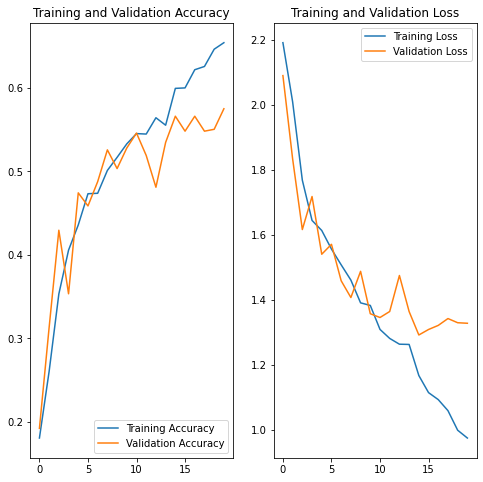

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

In [36]:

loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

14/14 [==============================] - 1s 38ms/step - loss: 1.3284 - accuracy: 0.5749
Accuracy:  0.6863839626312256
Validation Accuracy:  0.5749440789222717
Loss:  0.8953149914741516
Validation Loss 1.3284207582473755


# Model2 Findings : 

- - With the increase in no of epochs training and validation both accuracy increases
- - Training and validation accuracy are almost equal hence overfitting problem resolved
- - Current model is underfitting since the model accuracy has been decreased from .74 to .68
- - With the increase in no of epochs training and validation loss has been decreased

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [37]:
## Your code goes here.
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
path_list

['/Volumes/MyFiles/MachineLearning/upgrad/LiveCourse/Deep Learning/CNN/Convolutional-Neural-Networks-main/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0010550.jpg',
 '/Volumes/MyFiles/MachineLearning/upgrad/LiveCourse/Deep Learning/CNN/Convolutional-Neural-Networks-main/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0011128.jpg',
 '/Volumes/MyFiles/MachineLearning/upgrad/LiveCourse/Deep Learning/CNN/Convolutional-Neural-Networks-main/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0010587.jpg',
 '/Volumes/MyFiles/MachineLearning/upgrad/LiveCourse/Deep Learning/CNN/Convolutional-Neural-Networks-main/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0010034.jpg',
 '/Volumes/MyFiles/MachineLearning/upgrad/LiveCourse/Deep Learning/CNN/C

In [38]:
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [39]:
dataframe_dict = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
original_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


# Findings

- - 'seborrheic keratosis' class has least number of samples.
- - 'pigmented benign keratosis' and 'melanoma' class dominate the data in terms of proportionate number of samples.

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [40]:
!pip install Augmentor

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [41]:
path_to_training_dataset=str(data_dir_train) + '/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /Volumes/MyFiles/MachineLearning/upgrad/LiveCourse/Deep Learning/CNN/Convolutional-Neural-Networks-main/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2A4589040>: 100%|█|


Initialised with 376 image(s) found.
Output directory set to /Volumes/MyFiles/MachineLearning/upgrad/LiveCourse/Deep Learning/CNN/Convolutional-Neural-Networks-main/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1


Initialised with 95 image(s) found.
Output directory set to /Volumes/MyFiles/MachineLearning/upgrad/LiveCourse/Deep Learning/CNN/Convolutional-Neural-Networks-main/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2A2F1A970>: 100%|█|


Initialised with 438 image(s) found.
Output directory set to /Volumes/MyFiles/MachineLearning/upgrad/LiveCourse/Deep Learning/CNN/Convolutional-Neural-Networks-main/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x


Initialised with 357 image(s) found.
Output directory set to /Volumes/MyFiles/MachineLearning/upgrad/LiveCourse/Deep Learning/CNN/Convolutional-Neural-Networks-main/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2314x2067 at 0


Initialised with 462 image(s) found.
Output directory set to /Volumes/MyFiles/MachineLearning/upgrad/LiveCourse/Deep Learning/CNN/Convolutional-Neural-Networks-main/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x2


Initialised with 77 image(s) found.
Output directory set to /Volumes/MyFiles/MachineLearning/upgrad/LiveCourse/Deep Learning/CNN/Convolutional-Neural-Networks-main/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x2A47D25B0>: 100%|█


Initialised with 181 image(s) found.
Output directory set to /Volumes/MyFiles/MachineLearning/upgrad/LiveCourse/Deep Learning/CNN/Convolutional-Neural-Networks-main/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2A75944C0>: 100%|█|


Initialised with 139 image(s) found.
Output directory set to /Volumes/MyFiles/MachineLearning/upgrad/LiveCourse/Deep Learning/CNN/Convolutional-Neural-Networks-main/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x3094C2820>: 100%|█|


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [42]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [43]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/Volumes/MyFiles/MachineLearning/upgrad/LiveCourse/Deep Learning/CNN/Convolutional-Neural-Networks-main/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010741.jpg_657e94ae-2a5f-40b6-a0ea-3c2a97f6d11c.jpg',
 '/Volumes/MyFiles/MachineLearning/upgrad/LiveCourse/Deep Learning/CNN/Convolutional-Neural-Networks-main/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000292.jpg_a32e6b45-542b-4c2c-a6d8-252a8f369bd2.jpg',
 '/Volumes/MyFiles/MachineLearning/upgrad/LiveCourse/Deep Learning/CNN/Convolutional-Neural-Networks-main/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010789.jpg_d701338c-e2f4-4333-aef5-0dddc73141a7.jpg',
 '/Volumes/MyFiles/MachineLearning/upgrad/LiveCourse/Deep Learning/CNN/Convolutional-Neural-Networks-main/

In [44]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [45]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [46]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [47]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [48]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [49]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [50]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [51]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

### Your code goes here

input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential()
#normalisation layer
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
# First Conv layer
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding ='same' ,input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding ='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding ='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding ='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding ='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))

model.add(Dense(9,kernel_regularizer=l2(0.01)))
model.add(Activation('softmax'))

## Number of classes is 9
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 22, 22, 64)       

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [52]:
## Your code goes here
from tensorflow.keras.optimizers import Adam
### Todo, choose an appropirate optimiser and loss function
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [53]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[learning_rate_reduction]
)

Epoch 1/30


2022-04-20 00:21:25.644141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


169/169 [==============================] - ETA: 0s - loss: 1.9780 - accuracy: 0.2576

2022-04-20 00:21:47.346577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


169/169 [==============================] - 25s 144ms/step - loss: 1.9780 - accuracy: 0.2576 - val_loss: 1.5950 - val_accuracy: 0.3935
Epoch 2/30
169/169 [==============================] - 25s 143ms/step - loss: 1.5810 - accuracy: 0.3952 - val_loss: 1.4738 - val_accuracy: 0.4491
Epoch 3/30
169/169 [==============================] - 24s 142ms/step - loss: 1.4473 - accuracy: 0.4534 - val_loss: 1.3087 - val_accuracy: 0.4892
Epoch 4/30
169/169 [==============================] - 25s 143ms/step - loss: 1.3157 - accuracy: 0.5024 - val_loss: 1.2784 - val_accuracy: 0.5078
Epoch 5/30
169/169 [==============================] - 25s 145ms/step - loss: 1.2003 - accuracy: 0.5365 - val_loss: 1.1664 - val_accuracy: 0.5531
Epoch 6/30
169/169 [==============================] - 27s 157ms/step - loss: 1.1173 - accuracy: 0.5799 - val_loss: 1.2098 - val_accuracy: 0.5345
Epoch 7/30
169/169 [==============================] - 26s 153ms/step - loss: 0.9518 - accuracy: 0.6482 - val_loss: 0.9642 - val_accuracy: 0.6

In [54]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

43/43 [==============================] - 3s 64ms/step - loss: 0.3826 - accuracy: 0.8842
Accuracy:  0.9527077078819275
Validation Accuracy:  0.8841871023178101
Loss:  0.12356099486351013
Validation Loss 0.3825798034667969


#### **Todo:**  Visualize the model results

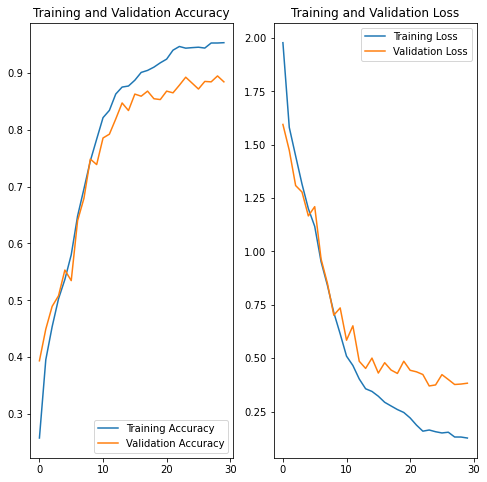

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



# Model3 Findings and Conclusions

 - Final model has no overfitting or underfitting
 - Training accuracy is 95 % and validation accuracy is 88.42 %
 - We can observe significance improvement in training and validation accuracy after using Augmentor and treating imbalance of all the classes
 - More epochs can be added to increase the accuracy Further
 - Training and validation loss has been decreased with the increase in no of epochs